In [1]:
import numpy as np
import torch
import torchvision
import unicodedata
import string
import re
import random
import pickle as pkl
from torch import nn
from torch.autograd import Variable

def load_tsv(filename):
    phID, stcID, ph, sentiment = [],[],[],[]
    with open(filename) as f: 
        l = f.readline()
        if (len(l.split("\t")) == 4):
            '''TRAIN dataset'''
            for line in f:
                l = line.split("\t")
                if (int(l[3][0]) < 2):
                    phID.append(l[0]), stcID.append(l[1]), ph.append(l[2]), sentiment.append(0)
                else:
                    phID.append(l[0]), stcID.append(l[1]), ph.append(l[2]), sentiment.append(1)
        else:
            for line in f:
                l = line.split("\t")
                phID.append(l[0]), stcID.append(l[1]), ph.append(l[2])
                
    return np.array(phID).astype(int), np.array(stcID).astype(int), np.array(ph), np.array(sentiment).astype(int)

        
    
phraseID, sentenceID, sentences, sentiment = load_tsv("SKIM-RNN/train.tsv")

In [38]:
'''Trim, Store, Count, Index words from dataset'''

SOS_token = 0
EOS_token = 1

class Preprocesser():
    
    '''main functions'''
    def __init__(self,corpus):
        '''corpus : np_array(string)'''
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS
        self.corpus = corpus
        self.size = len(corpus)
    
    # Lowercase, trim, and remove non-letter characters
    # (no stop words in skim rnn ?)
    def normalize(self):
        new_corpus = np.array([])
        steps,i = np.arange(0,self.size,self.size/10),0
        for s in self.corpus:
            uni_s = s.tostring().decode('unicode-escape')
            uni_s = self.unicodeToAscii(uni_s.lower().strip())
            uni_s = re.sub(r"([.!?])", r" \1", uni_s)
            uni_s = re.sub(r"[^a-zA-Z.!?]+", r" ", uni_s)
            new_corpus = np.append(new_corpus, uni_s)
            if (i in steps):
                print ("...")
            i+=1
        self.corpus = new_corpus


    def addSentences(self):
        for sentence in self.corpus:
            self.addSentence(sentence)
        
    '''called within the module:'''
    def unicodeToAscii(self,s):
        return ''.join(
            c for c in unicodedata.normalize('NFD', s)
            if unicodedata.category(c) != 'Mn'
        )

        
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
            
            
    def save(self,filename):
        pkl.dump(self.corpus,open(filename+"_corpus.pkl",'wb'))
        pkl.dump(self.word2count,open(filename+"_w2c.pkl",'wb'))
        pkl.dump(self.word2index,open(filename+"_w2i.pkl",'wb'))
        pkl.dump(self.index2word,open(filename+"_i2w.pkl", 'wb'))

 

In [39]:
preprocesser = Preprocesser(sentences)
preprocesser.normalize()
preprocesser.addSentences()

preprocesser.save("preprocessing_IMDB")


#corpus = pkl.load("preprocessing_IMDB_corpus.pkl")
#w2c = pkl.load("preprocessing_IMDB_w2c.pkl")
#w2i = pkl.load("preprocessing_IMDB_w2i.pkl")
#i2w = pkl.load("preprocessing_IMDB_i2w.pkl")

#preprocesser = Preprocesser(corpus)
#preprocesser.word2count = w2c
#preprocesser.index2word = i2w
#preprocesser.word2index = w2i
#preprocesser.n_words = len(word2count.keys())

...
...
...
...
...
...
...
...
...
...


In [40]:
'''RNN module : embedding layer -> gru layer -> linear layer (for output classification) -> softmax'''

class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        
        self.h20 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax()

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1 , 1, -1)
        output = embedded
        for i in range(self.n_layers):
            output, hidden = self.gru(output, hidden)
            output = self.h20(output)
            output = self.softmax(output)
            #lstm - > (input, (hidden,c <- ???) , cf pytorch doc, 'initial cell state')
        return output, hidden

    def initHidden(self):
        return Variable(torch.zeros(1, 1, self.hidden_size))

In [56]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def variableFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    result = Variable(torch.LongTensor(indexes).view(-1, 1))
    return result


def makeInputTarget(lang, sentence, target, n_classes=2):
    input_variable = variableFromSentence(lang, sentence)
    if target >= n_classes:
        print 'target not in range (0, #classes - 1)'
        return -1
    target_variable = Variable(torch.LongTensor([target]))
    return (input_variable, target_variable)


In [86]:
def train(input,target,rnn, optimizer, criterion):
    hidden = rnn.initHidden()

    rnn.zero_grad()
    input_length = input.size()[0]

    for ei in range(input_length):
        output, hidden = rnn(input[ei], hidden)
    
    loss = criterion(output.view(1,-1), target)
    loss.backward()

    optimizer.step()
    return output ,loss.data[0]


In [89]:
from torch import optim
rnn =  RNN(preprocesser.n_words, 128, 2)
criterion = nn.NLLLoss()
optimizer = optim.SGD(rnn.parameters(), lr=1e-1)
losses = []
for i in range(500):
    
    s,t =preprocesser.corpus[i], sentiment[i]
    input,target =  makeInputTarget(preprocesser, s, t)
    
    output, l = train(input,target,rnn,optimizer,criterion)
    losses.append(l)

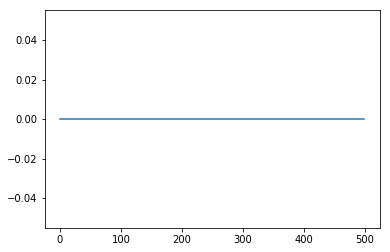

In [90]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(losses) 

In [64]:
len(sentences)

156060